# Testing Training Module

This notebook tests the complete training pipeline from `src.training`:
- Device detection
- Model summary utilities
- Training with noise augmentation
- Checkpoint save/load
- Training history visualization

In [7]:
# Add project root to Python path
import sys
from pathlib import Path
project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

print(f'Project root: {project_root}')

Project root: c:\Users\Arnav\Documents\Python Scripts\bird embeddings


## 1. Test Utility Functions

In [8]:
from src.training import get_device, set_seed, print_model_summary, count_parameters

# Test device detection
print('=== Device Detection ===')
device = get_device()
print(f'Using device: {device}\n')

# Test reproducibility
print('=== Random Seed ===')
set_seed(42)

=== Device Detection ===
✓ Using CPU
Using device: cpu

=== Random Seed ===
✓ Random seed set to: 42


In [9]:
from src.models import VariationalAutoencoder

# Create a small model for testing
print('=== Model Summary ===')
model = VariationalAutoencoder(
    input_dimension=100,
    latent_dimension=8,
    hidden_dimension=64
)

print_model_summary(model)

=== Model Summary ===
Model Summary
VariationalAutoencoder(
  (encoder_network): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
  )
  (latent_mean_layer): Linear(in_features=64, out_features=8, bias=True)
  (latent_log_variance_layer): Linear(in_features=64, out_features=8, bias=True)
  (decoder_network): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=100, bias=True)
    (7): Sigmoid()
  )
)
--------------------------------------------------------------------------------
Total parameters: 31,220
Trainable parameters: 31,220
Model size: 0.12 MB


In [10]:
# Test parameter counting
total, trainable = count_parameters(model)
print(f'\nParameter count:')
print(f'  Total: {total:,}')
print(f'  Trainable: {trainable:,}')


Parameter count:
  Total: 31,220
  Trainable: 31,220


## 2. Test Noise Augmentation

In [11]:
from src.training import add_noise
import torch

print('=== Noise Augmentation Test ===')

# Create sample data
clean_data = torch.tensor([
    [0.0, 1.0, 0.0, 1.0, 0.5],
    [1.0, 0.0, 1.0, 0.0, 0.3]
])

print('Clean data:')
print(clean_data)

# Add noise
noisy_data = add_noise(clean_data, noise_std=0.1)

print('\nNoisy data (noise_std=0.1):')
print(noisy_data)

print('\nDifference:')
print((noisy_data - clean_data).abs())

=== Noise Augmentation Test ===
Clean data:
tensor([[0.0000, 1.0000, 0.0000, 1.0000, 0.5000],
        [1.0000, 0.0000, 1.0000, 0.0000, 0.3000]])

Noisy data (noise_std=0.1):
tensor([[0.0405, 1.0000, 0.1100, 0.9755, 0.5971],
        [1.0000, 0.0058, 0.9911, 0.0646, 0.2063]])

Difference:
tensor([[0.0405, 0.0000, 0.1100, 0.0245, 0.0971],
        [0.0000, 0.0058, 0.0089, 0.0646, 0.0937]])


## 3. Prepare Small Dataset for Training Test

In [12]:
from src.data import load_ebird_data, create_species_matrix, split_train_val, create_dataloaders

print('=== Loading Small Dataset for Testing ===')

# Load small sample for quick testing
data = load_ebird_data(
    r"C:\Users\Arnav\Documents\Python Scripts\bird embeddings\data\raw\ebd_IN-KL_smp_relSep-2025.txt",
    nrows=20000
)

print('\nCreating species matrix...')
matrix, species = create_species_matrix(
    data,
    min_species_observations=20  # Filter rare species for faster training
)

print(f'\nFinal dataset: {matrix.shape[0]} checklists × {len(species)} species')

=== Loading Small Dataset for Testing ===
✓ Loaded eBird data from: ebd_IN-KL_smp_relSep-2025.txt
  Rows: 20,000
  Columns: 53
  (Limited to first 20,000 rows)

Creating species matrix...
Input data: 20,000 observations
✓ Loaded eBird data from: ebd_IN-KL_smp_relSep-2025.txt
  Rows: 20,000
  Columns: 53
  (Limited to first 20,000 rows)

Creating species matrix...
Input data: 20,000 observations
  Unique checklists: 1,498
  Unique species: 484

Applying quality filters...
  After CATEGORY='species': 18,537 observations (1,463 removed)
  After OBSERVATION TYPE filter: 14,603 observations (3,934 removed)
  After ALL SPECIES REPORTED=1: 10,996 observations (3,607 removed)

✓ Quality filters applied: 20,000 → 10,996 observations
  Removed: 9,004 (45.0%)

Filtered data:
  Unique checklists: 557
  Unique species: 342

Pivoting data to create species matrix...
✓ Initial matrix: 557 checklists × 342 species

Filtering species with < 20 observations...
✓ Removed 181 rare species
  Kept 161 speci

In [13]:
# Split into train/val
train_ds, val_ds = split_train_val(
    matrix,
    species,
    val_size=0.2,
    random_seed=42
)

# Create dataloaders
train_loader, val_loader = create_dataloaders(
    train_ds,
    val_ds,
    batch_size=64,
    num_workers=0  # Use 0 for Windows compatibility
)

✓ Split data: 446 train, 111 val
  Train/Val ratio: 4.02
✓ Created DataLoaders:
  Train: 7 batches of size 64
  Val: 2 batches of size 64
✓ Created DataLoaders:
  Train: 7 batches of size 64
  Val: 2 batches of size 64


## 4. Create and Test Training

In [14]:
# Create model sized for our data
model = VariationalAutoencoder(
    input_dimension=len(species),
    latent_dimension=8,
    hidden_dimension=128
)

print(f'Model input dimension: {len(species)}')
print(f'Model latent dimension: 8')
print(f'Model hidden dimension: 128')

total, _ = count_parameters(model)
print(f'\nTotal parameters: {total:,}')

Model input dimension: 161
Model latent dimension: 8
Model hidden dimension: 128

Total parameters: 110,769


In [15]:
from src.training import train_variational_autoencoder
import os

print('=== Training VAE (Quick Test - 10 Epochs) ===')
print(f'Device: {device}')
print(f'Batch size: 64')
print(f'Learning rate: 1e-3')
print(f'Noise std: 0.1')
print('\n' + '='*80 + '\n')

# Train for just 10 epochs (quick test)
history = train_variational_autoencoder(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,
    learning_rate=1e-3,
    noise_std=0.1,
    device=device,
    print_every=2,
    checkpoint_dir='test_checkpoints',
    save_every=5
)

=== Training VAE (Quick Test - 10 Epochs) ===
Device: cpu
Batch size: 64
Learning rate: 1e-3
Noise std: 0.1


Checkpoints will be saved to: test_checkpoints

Starting training on cpu...
Epochs: 10, Learning rate: 0.001, Noise std: 0.1
Train batches: 7, Val batches: 2
--------------------------------------------------------------------------------
Epoch   1/10 | Train Loss: 109.0848 (Recon: 109.0684, KL: 0.0163) | Val Loss: 102.8239 (Recon: 102.7978, KL: 0.0261)
Epoch   2/10 | Train Loss: 92.6336 (Recon: 92.5391, KL: 0.0945) | Val Loss: 73.9516 (Recon: 73.6777, KL: 0.2739)
Epoch   4/10 | Train Loss: 57.8735 (Recon: 57.6618, KL: 0.2117) | Val Loss: 52.9446 (Recon: 52.8780, KL: 0.0666)
  → Saved checkpoint: test_checkpoints\checkpoint_epoch_5.pt
Epoch   6/10 | Train Loss: 54.2114 (Recon: 54.1899, KL: 0.0215) | Val Loss: 51.7488 (Recon: 51.7287, KL: 0.0201)
Epoch   8/10 | Train Loss: 52.7249 (Recon: 52.7015, KL: 0.0235) | Val Loss: 50.6261 (Recon: 50.5866, KL: 0.0395)
Epoch  10/10 | Train 

In [16]:
# Check training history
print('\n=== Training History ===')
print(f'Epochs trained: {len(history["train_loss"])}')
print(f'\nFinal losses:')
print(f'  Train loss: {history["train_loss"][-1]:.4f}')
print(f'  Val loss: {history["val_loss"][-1]:.4f}')
print(f'\nLoss improvement:')
print(f'  Train: {history["train_loss"][0]:.4f} → {history["train_loss"][-1]:.4f} '
      f'({(history["train_loss"][-1] - history["train_loss"][0]) / history["train_loss"][0] * 100:.1f}%)')
print(f'  Val: {history["val_loss"][0]:.4f} → {history["val_loss"][-1]:.4f} '
      f'({(history["val_loss"][-1] - history["val_loss"][0]) / history["val_loss"][0] * 100:.1f}%)')


=== Training History ===
Epochs trained: 10

Final losses:
  Train loss: 51.2163
  Val loss: 48.7629

Loss improvement:
  Train: 109.0848 → 51.2163 (-53.0%)
  Val: 102.8239 → 48.7629 (-52.6%)


## 5. Visualize Training Curves

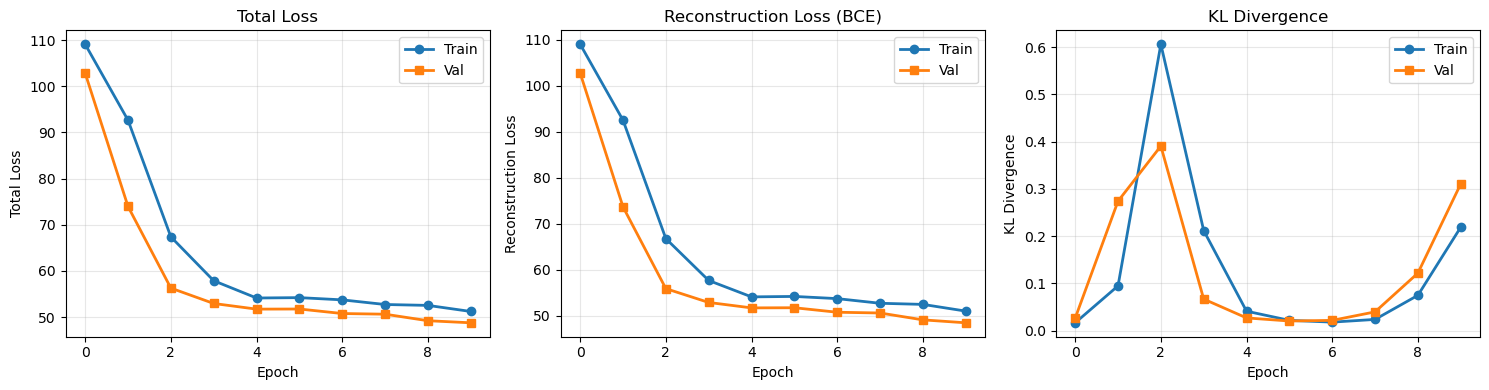

✓ Training curves look healthy! Both train and val losses decreasing.


In [17]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Total Loss
axes[0].plot(history['train_loss'], 'o-', label='Train', linewidth=2)
axes[0].plot(history['val_loss'], 's-', label='Val', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Total Loss')
axes[0].set_title('Total Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Reconstruction Loss
axes[1].plot(history['train_recon_loss'], 'o-', label='Train', linewidth=2)
axes[1].plot(history['val_recon_loss'], 's-', label='Val', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Reconstruction Loss')
axes[1].set_title('Reconstruction Loss (BCE)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: KL Divergence
axes[2].plot(history['train_kl_loss'], 'o-', label='Train', linewidth=2)
axes[2].plot(history['val_kl_loss'], 's-', label='Val', linewidth=2)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('KL Divergence')
axes[2].set_title('KL Divergence')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('✓ Training curves look healthy! Both train and val losses decreasing.')

## 6. Test Checkpoint Save/Load

In [18]:
from src.training import save_checkpoint, load_checkpoint

print('=== Testing Manual Checkpoint Save ===')

# Save checkpoint manually
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

save_checkpoint(
    model=model,
    optimizer=optimizer,
    epoch=10,
    train_loss=history['train_loss'][-1],
    val_loss=history['val_loss'][-1],
    filepath='test_checkpoints/manual_checkpoint.pt',
    history=history,
    metadata={
        'input_dim': len(species),
        'latent_dim': 8,
        'hidden_dim': 128,
        'noise_std': 0.1
    }
)

=== Testing Manual Checkpoint Save ===
✓ Saved checkpoint to: test_checkpoints/manual_checkpoint.pt


In [19]:
print('\n=== Testing Checkpoint Load ===')

# Create new model and load checkpoint
new_model = VariationalAutoencoder(
    input_dimension=len(species),
    latent_dimension=8,
    hidden_dimension=128
)
new_optimizer = torch.optim.Adam(new_model.parameters(), lr=1e-3)

checkpoint = load_checkpoint(
    filepath='test_checkpoints/manual_checkpoint.pt',
    model=new_model,
    optimizer=new_optimizer,
    device=device
)

print(f'\nLoaded metadata:')
for key, value in checkpoint['metadata'].items():
    print(f'  {key}: {value}')


=== Testing Checkpoint Load ===
✓ Loaded checkpoint from: test_checkpoints/manual_checkpoint.pt
  Epoch: 10
  Train loss: 51.2163
  Val loss: 48.7629

Loaded metadata:
  input_dim: 161
  latent_dim: 8
  hidden_dim: 128
  noise_std: 0.1


In [20]:
# Verify loaded model produces same output
print('\n=== Verifying Loaded Model ===')

# Get a test batch
test_batch = next(iter(val_loader))

# Compare outputs
model.eval()
new_model.eval()

# Note: VAE uses reparameterization trick which involves random sampling
# So we need to set seed to get identical outputs, OR compare state dicts
print('Comparing model state dicts (weights)...')
state_match = True
for key in model.state_dict().keys():
    if not torch.equal(model.state_dict()[key], new_model.state_dict()[key]):
        state_match = False
        print(f'  Mismatch in: {key}')
        break

if state_match:
    print('✓ Model weights are identical!')
else:
    print('✗ Model weights differ (this should not happen)')

# Also test with same seed for forward pass
print('\nComparing outputs with same random seed...')
torch.manual_seed(123)
with torch.no_grad():
    output1, _, _ = model(test_batch.to(device))

torch.manual_seed(123)  # Same seed
with torch.no_grad():
    output2, _, _ = new_model(test_batch.to(device))
    
difference = (output1 - output2).abs().max().item()
print(f'Max difference between outputs: {difference:.10f}')

if difference < 1e-6:
    print('✓ Outputs are identical (with same seed)!')
else:
    print(f'✗ Outputs still differ by {difference:.6f} (unexpected!)')


=== Verifying Loaded Model ===
Comparing model state dicts (weights)...
✓ Model weights are identical!

Comparing outputs with same random seed...
Max difference between outputs: 0.0000000000
✓ Outputs are identical (with same seed)!


## 7. Test Different Training Strategies

In [21]:
print('=== Testing Training WITHOUT Noise ===')

# Create fresh model
model_no_noise = VariationalAutoencoder(
    input_dimension=len(species),
    latent_dimension=8,
    hidden_dimension=128
)

# Train without noise
history_no_noise = train_variational_autoencoder(
    model=model_no_noise,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=5,
    learning_rate=1e-3,
    noise_std=0.0,  # NO NOISE
    device=device,
    print_every=2
)

print(f'\nFinal val loss (no noise): {history_no_noise["val_loss"][-1]:.4f}')
print(f'Final val loss (with noise): {history["val_loss"][-1]:.4f}')

=== Testing Training WITHOUT Noise ===

Starting training on cpu...
Epochs: 5, Learning rate: 0.001, Noise std: 0.0
Train batches: 7, Val batches: 2
--------------------------------------------------------------------------------
Epoch   1/5 | Train Loss: 107.6278 (Recon: 107.6142, KL: 0.0136) | Val Loss: 100.4780 (Recon: 100.4576, KL: 0.0205)
Epoch   2/5 | Train Loss: 89.9548 (Recon: 89.8867, KL: 0.0680) | Val Loss: 71.9170 (Recon: 71.7361, KL: 0.1809)
Epoch   4/5 | Train Loss: 57.0964 (Recon: 56.9751, KL: 0.1213) | Val Loss: 53.1558 (Recon: 53.1073, KL: 0.0486)
--------------------------------------------------------------------------------
✓ Training complete!
  Final train loss: 54.3237
  Final val loss: 52.3291

Final val loss (no noise): 52.3291
Final val loss (with noise): 48.7629


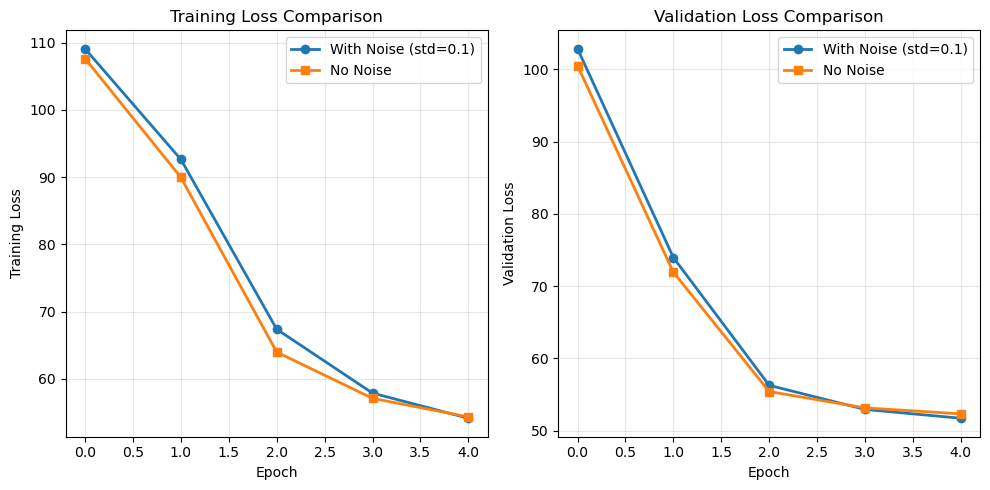

Note: Training with noise acts as regularization.
It may have slightly higher training loss but often better generalization.


In [22]:
# Compare training with and without noise
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'][:5], 'o-', label='With Noise (std=0.1)', linewidth=2)
plt.plot(history_no_noise['train_loss'], 's-', label='No Noise', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history['val_loss'][:5], 'o-', label='With Noise (std=0.1)', linewidth=2)
plt.plot(history_no_noise['val_loss'], 's-', label='No Noise', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('Note: Training with noise acts as regularization.')
print('It may have slightly higher training loss but often better generalization.')

## 8. Test Model Inference

In [23]:
print('=== Testing Model Inference ===')

# Get a sample checklist
sample_batch = next(iter(val_loader))[:5]  # Get 5 samples

model.eval()
with torch.no_grad():
    sample_batch = sample_batch.to(device)
    reconstructed, latent_mean, latent_logvar = model(sample_batch)

print(f'Input shape: {sample_batch.shape}')
print(f'Reconstructed shape: {reconstructed.shape}')
print(f'Latent mean shape: {latent_mean.shape}')
print(f'Latent logvar shape: {latent_logvar.shape}')

# Compare original and reconstructed
print(f'\nSample checklist 0:')
print(f'  Original species count: {sample_batch[0].sum().item():.0f}')
print(f'  Reconstructed species count (prob > 0.5): {(reconstructed[0] > 0.5).sum().item():.0f}')
print(f'  Reconstruction error (MSE): {((sample_batch[0] - reconstructed[0])**2).mean().item():.4f}')

print(f'\nLatent representation (8D vector):')
print(latent_mean[0].cpu().numpy().round(3))

=== Testing Model Inference ===
Input shape: torch.Size([5, 161])
Reconstructed shape: torch.Size([5, 161])
Latent mean shape: torch.Size([5, 8])
Latent logvar shape: torch.Size([5, 8])

Sample checklist 0:
  Original species count: 4
  Reconstructed species count (prob > 0.5): 0
  Reconstruction error (MSE): 0.0262

Latent representation (8D vector):
[-0.161  0.1   -0.25   0.018  0.015  0.188 -0.281 -0.052]


## 9. Cleanup Test Files

In [24]:
import shutil

print('=== Cleaning Up Test Checkpoints ===')

# Remove test checkpoint directory
if os.path.exists('test_checkpoints'):
    shutil.rmtree('test_checkpoints')
    print('✓ Removed test_checkpoints/ directory')
else:
    print('No test checkpoints to clean up')

=== Cleaning Up Test Checkpoints ===
✓ Removed test_checkpoints/ directory


## Summary

If all cells above ran successfully, the training module is working correctly! ✅

**Tested:**
1. ✓ Device detection (CPU/CUDA/MPS)
2. ✓ Model summary and parameter counting
3. ✓ Noise augmentation
4. ✓ Training with noise (denoising VAE)
5. ✓ Training without noise (pure VAE)
6. ✓ Checkpoint saving and loading
7. ✓ Training history tracking
8. ✓ Model inference

**You can now:**
- Train VAE models with `train_variational_autoencoder()`
- Save and load checkpoints
- Compare different training strategies
- Monitor training with detailed loss tracking